In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from tqdm.notebook import tqdm, tnrange
from PIL import Image
import matplotlib.pyplot as plt
import torchsummary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
# Set random seed for reproducibility
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

### Încăracarea setului de date
Folosim LFWfunneled ca set de date, având o aliniere mai bună a fețelor.

In [3]:
lfw_dataset = foz.load_zoo_dataset(
    "lfw",
    split="train",
    shuffle=True,
    seed=0
)
# load data from local
# lfw_dataset = fo.Dataset.from_dir(
#     dataset_dir='/home/ichitu/fiftyone/lfw/lfw_funneled',
#     dataset_type=fo.types.dataset_types.ImageClassificationDirectoryTree,
#     name='lfw_funneled',
#     overwrite=True,
    
# )




Split 'train' already downloaded


Loading existing dataset 'lfw-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [4]:
DIM = 224

Crearea unui set de date custom pentru a avea acces prin index la imagini, dar și la etichete pentru o identificare facilă a persoanelor

In [5]:
class LFWDataset:
    def __init__(self, dataset, dim=DIM):
        self.dataset = dataset
        self.filepaths = list(dataset.values("filepath"))
        self.dim = dim
    
    def __len__(self):
        return len(self.filepaths)
    
    def preprocess(self, image, dim):
        image = image.resize((dim, dim))
        return image
    
    def image_path(self, idx):
        return self.filepaths[idx]
    
    def __getitem__(self, idx):
        impath = self.filepaths[idx]
        sample = self.dataset[impath]
        image = Image.open(impath).convert("RGB")
        image = self.preprocess(image, self.dim)
        image = np.array(image)
        label = sample["ground_truth"]["label"]
        return image, label
    
full_dataset = LFWDataset(lfw_dataset, dim=DIM)
print(full_dataset.image_path(7))

/home/ichitu/fiftyone/lfw/train/Sharon_Stone/Sharon_Stone_0005.jpg


### Alegerea perechilor
Conform articolului http://www.whdeng.cn/FGLFW/FGLFW.html alegerea aleatorie a imaginilor duce la o acuratețe mare falsă, imaginile negative fiind cu mult diferite de ancore. Din această cauză folosim un fișier text pentru selectarea perechilor, care la fiecare 600 de linii are 300 de perechi matched, apoi 300 mismatched, alternând între ele de 10 ori. Astfel rezultă 10 seturi cu câte 1200 imagini fiecare

In [6]:
def parse_fglfw_pairs(file_path, dataset_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines()]

    sets = []
    idx = 0
    # Each set has 600 lines for matched (300 pairs) and 600 lines for mismatched (300 pairs)
    for _ in range(10):
        matched = []
        mismatched = []
        # Read 300 matched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            matched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        # Read 300 mismatched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            mismatched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        sets.append({"matched": matched, "mismatched": mismatched})

    return sets

In [7]:
file_path = "/home/ichitu/fiftyone/lfw/lfw_funneled/pair_FGLFW.txt"
pairs = parse_fglfw_pairs(file_path, "/home/ichitu/fiftyone/lfw/lfw_funneled")
print("Parsed", len(pairs), "sets.")
print("Each set has:", len(pairs[0]["matched"]), "matched pairs and", len(pairs[0]["mismatched"]), "mismatched pairs.")

Parsed 10 sets.
Each set has: 300 matched pairs and 300 mismatched pairs.


Generarea de batch-uri pe baza perechilor formate mai sus

In [8]:
def batch_generator(dataset, pairs, batch_size, dim=DIM, dataset_path="/home/ichitu/fiftyone/lfw/lfw_funneled"):
    dataset_size = len(dataset)
    if dataset_size < batch_size:
        raise ValueError("Dataset size is smaller than the batch size. \
                         Cannot generate batches.")
    
    anchors_positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
               [""] * batch_size]
    positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    anchors_negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    while True:
        for i in range(batch_size):
            # Select a random set
            set_ = random.choice(pairs)
            # Select a random matched pair
            matched_pair = random.choice(set_["matched"])
            # Select a random mismatched pair
            mismatched_pair = random.choice(set_["mismatched"])
            # Load the images
            anchor_positive = Image.open(matched_pair[0]).convert("RGB")
            positive = Image.open(matched_pair[1]).convert("RGB")
            anchors_negative = Image.open(mismatched_pair[0]).convert("RGB")
            negative = Image.open(mismatched_pair[1]).convert("RGB")
            # Preprocess the images
            anchor_positive = anchor_positive.resize((dim, dim))
            positive = positive.resize((dim, dim))
            anchors_negative = anchors_negative.resize((dim, dim))
            negative = negative.resize((dim, dim))
            # Convert to numpy arrays
            anchor_positive = np.array(anchor_positive)
            positive = np.array(positive)
            anchors_negative = np.array(anchors_negative)
            negative = np.array(negative)
            # Add to the batch
            anchors_positives[0][i] = anchor_positive
            anchors_positives[1][i] = matched_pair[0]
            positives[0][i] = positive
            positives[1][i] = matched_pair[1]
            anchors_positives[0][i] = anchor_positive / 255.
            anchors_positives[1][i] = matched_pair[0].replace(dataset_path + "/","").split("/")[0]
            positives[0][i] = positive / 255.
            positives[1][i] = matched_pair[1].replace(dataset_path + "/","").split("/")[0]
            anchors_negatives[0][i] = anchors_negative / 255.
            anchors_negatives[1][i] = mismatched_pair[0].replace(dataset_path + "/","").split("/")[0]
            negatives[0][i] = negative / 255.
            negatives[1][i] = mismatched_pair[1].replace(dataset_path + "/","").split("/")[0]
        yield [anchors_positives, positives, anchors_negatives, negatives]
        


Generarea în mod aleator a batch-urilor

In [9]:
def batch_generator3(dataset, batch_size, dim=DIM):
    dataset_size = len(dataset)
    if dataset_size < batch_size:
        raise ValueError("Dataset size is smaller than the batch size. \
                         Cannot generate batches.")
    
    anchors = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
               [""] * batch_size]
    positives = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
                 [""] * batch_size]
    negatives = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
                 [""] * batch_size]

    while True:
        for i in range(batch_size):
            if len(dataset) <= 0:  # Check if the dataset is exhausted
                return  # Stop the generator if the dataset is empty
            anchor_idx = np.random.randint(len(dataset))
            anchor, label = dataset[anchor_idx]
            positive_indices = np.where(np.array(dataset.dataset.values(
                "ground_truth.label")) == label)[0]
            negative_indices = np.where(np.array(dataset.dataset.values(
                "ground_truth.label")) != label)[0]
            if len(positive_indices) == 0 or len(negative_indices) == 0:  
                # Check if no valid pairs are available
                continue
            positive_idx = np.random.choice(positive_indices)
            negative_idx = np.random.choice(negative_indices)
            positive, positive_label = dataset[positive_idx]
            negative, negative_label = dataset[negative_idx]

            anchors[0][i] = anchor
            anchors[1][i] = label
            positives[0][i] = positive
            positives[1][i] = positive_label
            negatives[0][i] = negative
            negatives[1][i] = negative_label

        yield anchors, positives, negatives


Testez generatorul

In [10]:
BS = 1
generator = batch_generator(full_dataset, pairs, BS)

['Rita_Grande']
['Rita_Grande']
['Dick_Clark']
['Howard_Dean']


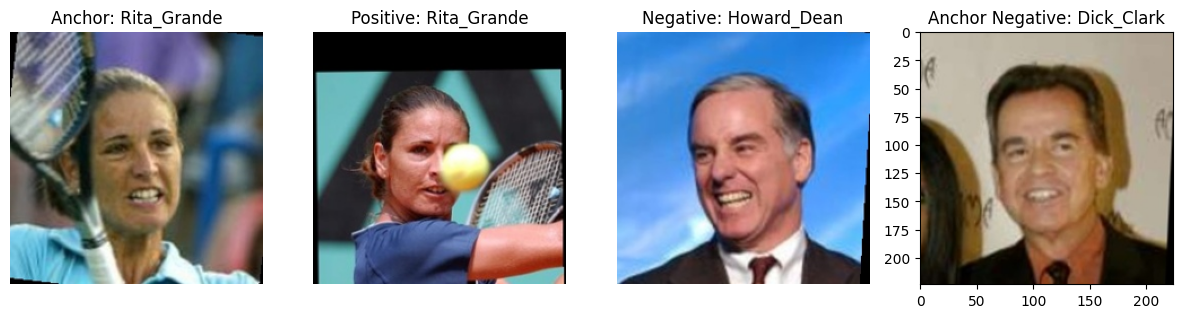

In [11]:
# Get a batch of data
batch = next(generator)
anchor = batch[0]
positive = batch[1]
anchor_negative = batch[2]
negative = batch[3]
print(anchor[1])
print(positive[1])
print(anchor_negative[1])
print(negative[1])
for i in range(BS):
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    ax[0].imshow(anchor[0][i])
    ax[0].set_title("Anchor:" + " " + anchor[1][i])
    ax[0].axis("off")
    ax[1].imshow(positive[0][i])
    ax[1].set_title("Positive:" + " " + positive[1][i])
    ax[1].axis("off")
    ax[2].imshow(negative[0][i])
    ax[2].set_title("Negative:" + " " + negative[1][i])
    ax[2].axis("off")
    ax[3].imshow(anchor_negative[0][i])
    ax[3].set_title("Anchor Negative:" + " " + anchor_negative[1][i])
    plt.show()

### Modelele


##### Model după Zeiler-Fergus
Am încercat implementarea lui, dar nu am reușit, neclarități în cum ar trebui implementat conform https://arxiv.org/pdf/1503.03832

In [12]:
class FaceRecZF(nn.Module):
    def __init__(self, input_shape = (3, 220, 220)):
        super(FaceRecZF, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.rnorm1 = nn.LocalResponseNorm(size=1)
        self.conv2a = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.rnorm2 = nn.LocalResponseNorm(size=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv3a = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv4a = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.concat = nn.Flatten()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc7132 = nn.Linear(128, 128)

    def L2Norm(self, x):
        return F.normalize(x, p=2, dim=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.rnorm1(x)
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2(x))
        x = self.rnorm2(x)
        x = self.pool2(x)
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4a(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5a(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6a(x))
        x = F.relu(self.conv6(x))
        x = self.pool4(x)
        # x = self.concat(x)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc7132(x)
        return x
    

In [13]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FaceRecZF().to(device)
# torchsummary.summary(model, (3, 220, 220))

### Model după GoogleLeNet
Tot conform articolului de mai sus, dar pentru blocurile de inception am folosit publicația https://arxiv.org/pdf/1409.4842

<img src="/home/ichitu/py-files/Resources/Captură de ecran 2025-01-20 112241.png">

In [14]:
class FaceRecInception(nn.Module):
    def __init__(self, input_shape=(3, 220, 220)):
        super(FaceRecInception, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.rnorm1 = nn.LocalResponseNorm(size=1)
        
        # Inception Module 1
        def inception_block1(in_channels, out_channels):
            conv3x3_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv3x3 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, padding=1)
            return nn.Sequential(
                conv3x3_reduce,
                nn.ReLU(),
                conv3x3,
                nn.ReLU()
            )    
        self.inception1 = inception_block1(64, [64, 192])

        self.rnorm2 = nn.LocalResponseNorm(size=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Modules 1x1, 3x3, 5x5, and Pooling
        def inception_block1x1(in_channels, out_channels):
            conv1x1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            return nn.Sequential(
                conv1x1,
                nn.ReLU()
            )
        def inception_block3x3(in_channels, out_channels, stride=1):
            conv3x3_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv3x3 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, padding=1, stride=stride)
            return nn.Sequential(
                conv3x3_reduce,
                nn.ReLU(),
                conv3x3,
                nn.ReLU()
            )
        def inception_block5x5(in_channels, out_channels, stride=1):
            conv5x5_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv5x5 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=5, padding=2, stride=stride)
            return nn.Sequential(
                conv5x5_reduce,
                nn.ReLU(),
                conv5x5,
                nn.ReLU()
            )
        
        class L2Pooling(nn.Module):
            def __init__(self):
                super(L2Pooling, self).__init__()
            def forward(self, x):
                return torch.sqrt(F.avg_pool2d(x**2, kernel_size=3, stride=1, padding=1))

        def pool_proj(in_channels, out_channels, max_pool=True):
            if max_pool:
                return nn.Sequential(
                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1),
                    nn.ReLU()
                   )
            else:
                return nn.Sequential(
                    L2Pooling(),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1),
                    nn.ReLU()
                )
        
        # Inception Module 3a
        self.inception3a1x1 = inception_block1x1(192, [64])
        self.inception3a3x3 = inception_block3x3(192, [96, 128])
        self.inception3a5x5 = inception_block5x5(192, [16, 32])
        self.inception3apool = pool_proj(192, 32, max_pool=True)

        # Inception Module 3b
        self.inception3b1x1 = inception_block1x1(256, [64])
        self.inception3b3x3 = inception_block3x3(256, [96, 128])
        self.inception3b5x5 = inception_block5x5(256, [32, 64])
        self.inception3bpool = pool_proj(256, 64, max_pool=False)

        # Inception Module 3c
        self.inception3c3x3 = inception_block3x3(320, [128, 256], stride=2)
        self.inception3c5x5 = inception_block5x5(320, [32, 64], stride=2)
        self.inception3cpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Module 4a
        self.inception4a1x1 = inception_block1x1(640, [256])
        self.inception4a3x3 = inception_block3x3(640, [96, 192])
        self.inception4a5x5 = inception_block5x5(640, [32, 64])
        self.inception4apool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4b
        self.inception4b1x1 = inception_block1x1(640, [DIM])
        self.inception4b3x3 = inception_block3x3(640, [112, DIM])
        self.inception4b5x5 = inception_block5x5(640, [32, 64])
        self.inception4bpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4c
        self.inception4c1x1 = inception_block1x1(640, [192])
        self.inception4c3x3 = inception_block3x3(640, [128, 256])
        self.inception4c5x5 = inception_block5x5(640, [32, 64])
        self.inception4cpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4d
        self.inception4d1x1 = inception_block1x1(640, [160])
        self.inception4d3x3 = inception_block3x3(640, [144, 288])
        self.inception4d5x5 = inception_block5x5(640, [32, 64])
        self.inception4dpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4e
        self.inception4e3x3 = inception_block3x3(640, [160, 256], stride=2)
        self.inception4e5x5 = inception_block5x5(640, [64, 128], stride=2)
        self.inception4epool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Module 5a
        self.inception5a1x1 = inception_block1x1(1024, [384])
        self.inception5a3x3 = inception_block3x3(1024, [192, 384])
        self.inception5a5x5 = inception_block5x5(1024, [48, 128])
        self.inception5apool = pool_proj(1024, 128, max_pool=False)

        # Inception Module 5b
        self.inception5b1x1 = inception_block1x1(1024, [384])
        self.inception5b3x3 = inception_block3x3(1024, [192, 384])
        self.inception5b5x5 = inception_block5x5(1024, [48, 128])
        self.inception5bpool = pool_proj(1024, 128, max_pool=True)

        # Final Pooling and Fully Connected Layer
        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc1 = nn.Linear(1024, 128)

        # L2 Normalization
        def L2Norm(x):
            return F.normalize(x, p=2, dim=1)
        self.L2Norm = L2Norm

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.rnorm1(x)
        x = self.inception1(x)
        x = self.rnorm2(x)
        x = self.max_pool2(x)

        # Inception Module 3a
        inception3a1x1 = self.inception3a1x1(x)
        inception3a3x3 = self.inception3a3x3(x)
        inception3a5x5 = self.inception3a5x5(x)
        inception3apool = self.inception3apool(x)
        x = torch.cat([inception3a1x1, inception3a3x3, inception3a5x5, inception3apool], 1)

        # Inception Module 3b
        inception3b1x1 = self.inception3b1x1(x)
        inception3b3x3 = self.inception3b3x3(x)
        inception3b5x5 = self.inception3b5x5(x)
        inception3bpool = self.inception3bpool(x)
        x = torch.cat([inception3b1x1, inception3b3x3, inception3b5x5, inception3bpool], 1)

        # Inception Module 3c
        inception3c3x3 = self.inception3c3x3(x)
        inception3c5x5 = self.inception3c5x5(x)
        inception3cpool = self.inception3cpool(x)
        x = torch.cat([inception3c3x3, inception3c5x5, inception3cpool], 1)

        # Inception Module 4a
        inception4a1x1 = self.inception4a1x1(x)
        inception4a3x3 = self.inception4a3x3(x)
        inception4a5x5 = self.inception4a5x5(x)
        inception4apool = self.inception4apool(x)
        x = torch.cat([inception4a1x1, inception4a3x3, inception4a5x5, inception4apool], 1)

        # Inception Module 4b
        inception4b1x1 = self.inception4b1x1(x)
        inception4b3x3 = self.inception4b3x3(x)
        inception4b5x5 = self.inception4b5x5(x)
        inception4bpool = self.inception4bpool(x)
        x = torch.cat([inception4b1x1, inception4b3x3, inception4b5x5, inception4bpool], 1)

        # Inception Module 4c
        inception4c1x1 = self.inception4c1x1(x)
        inception4c3x3 = self.inception4c3x3(x)
        inception4c5x5 = self.inception4c5x5(x)
        inception4cpool = self.inception4cpool(x)
        x = torch.cat([inception4c1x1, inception4c3x3, inception4c5x5, inception4cpool], 1)

        # Inception Module 4d
        inception4d1x1 = self.inception4d1x1(x)
        inception4d3x3 = self.inception4d3x3(x)
        inception4d5x5 = self.inception4d5x5(x)
        inception4dpool = self.inception4dpool(x)
        x = torch.cat([inception4d1x1, inception4d3x3, inception4d5x5, inception4dpool], 1)

        # Inception Module 4e
        inception4e3x3 = self.inception4e3x3(x)
        inception4e5x5 = self.inception4e5x5(x)
        inception4epool = self.inception4epool(x)
        x = torch.cat([inception4e3x3, inception4e5x5, inception4epool], 1)

        # Inception Module 5a
        inception5a1x1 = self.inception5a1x1(x)
        inception5a3x3 = self.inception5a3x3(x)
        inception5a5x5 = self.inception5a5x5(x)
        inception5apool = self.inception5apool(x)
        x = torch.cat([inception5a1x1, inception5a3x3, inception5a5x5, inception5apool], 1)

        # Inception Module 5b
        inception5b1x1 = self.inception5b1x1(x)
        inception5b3x3 = self.inception5b3x3(x)
        inception5b5x5 = self.inception5b5x5(x)
        inception5bpool = self.inception5bpool(x)
        x = torch.cat([inception5b1x1, inception5b3x3, inception5b5x5, inception5bpool], 1)

        # Final Pooling and Fully Connected Layer
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        # L2 Normalization
        x = self.L2Norm(x)
        return x

**Sumarizarea modelului**

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_inception = FaceRecInception().to(device)
# print(model)
torchsummary.summary(model_inception, (3, DIM, DIM))
# export as onnx
# dummy_input = torch.randn(1, 3, DIM, DIM).to(device)
# torch.onnx.export(model_inception, dummy_input, "model_inception.onnx", 
#                   verbose=True, input_names=["input"], output_names=["output"],
#                   opset_version=9)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
 LocalResponseNorm-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
              ReLU-7          [-1, 192, 56, 56]               0
 LocalResponseNorm-8          [-1, 192, 56, 56]               0
         MaxPool2d-9          [-1, 192, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]          12,352
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 96, 28, 28]          18,528
             ReLU-13           [-1, 96, 28, 28]               0
           Conv2d-14          [-1, 128,

**Asigurarea că ponderile nu sunt inițializate cu 0**

In [16]:
# ...existing code...
for name, param in model_inception.named_parameters():
    print(name, param.mean().item(), param.std().item())
# ...existing code...

conv1.weight -0.0003565644146874547 0.04783247411251068
conv1.bias 0.00013661314733326435 0.04757082089781761
inception1.0.weight -0.0001234403025591746 0.07224268466234207
inception1.0.bias -0.010804198682308197 0.06866342574357986
inception1.2.weight -1.649562909733504e-05 0.024055039510130882
inception1.2.bias -0.0010439860634505749 0.023628175258636475
inception3a1x1.0.weight -0.0007039799238555133 0.04165446013212204
inception3a1x1.0.bias 0.0002438458614051342 0.04629924148321152
inception3a3x3.0.weight -0.0008868666482158005 0.04163036495447159
inception3a3x3.0.bias -0.010149717330932617 0.04223301261663437
inception3a3x3.2.weight -1.817616976040881e-05 0.019610298797488213
inception3a3x3.2.bias 0.0011043008416891098 0.020167196169495583
inception3a5x5.0.weight 0.00038923750980757177 0.04170047119259834
inception3a5x5.0.bias 0.010830068960785866 0.034681208431720734
inception3a5x5.2.weight 0.0001363388728350401 0.028966376557946205
inception3a5x5.2.bias -0.011998550966382027 0.03

### Calcularea puterii de calucul necesare
**Încercarea cu profiler de la torch**

In [17]:
# get the number of FLOPs and number of parameters
import torch.profiler

model = FaceRecInception().to(device)
model.eval()
inputs = torch.randn(100, 3, DIM, DIM).to(device)
# Use the profiler to estimate FLOPS
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    with_flops=True
    ) as prof:
    model(inputs)

# Print the profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::cudnn_convolution        43.24%      30.565ms        83.42%      58.965ms     999.409us      20.098ms        32.68%      20.098ms     340.637us            59            --  
                                        aten::clamp_min         0.78%     554.241us         3.27%       2.309ms      38.484us       6.653ms        10.8

**Încercarea cu o librăria https://github.com/facebookresearch/fvcore**

In [18]:
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, inputs)
print(f"FLOPs: {flops.total()/1e9:.2f} G")

Unsupported operator aten::max_pool2d encountered 6 time(s)


Unsupported operator aten::mul encountered 4 time(s)


Unsupported operator aten::pad encountered 2 time(s)


Unsupported operator aten::avg_pool3d encountered 2 time(s)


Unsupported operator aten::add encountered 2 time(s)


Unsupported operator aten::pow encountered 8 time(s)


Unsupported operator aten::div encountered 3 time(s)


Unsupported operator aten::avg_pool2d encountered 7 time(s)


Unsupported operator aten::sqrt encountered 6 time(s)


Unsupported operator aten::linalg_vector_norm encountered 1 time(s)


Unsupported operator aten::clamp_min encountered 1 time(s)


Unsupported operator aten::expand_as encountered 1 time(s)


FLOPs: 159.65 G


##### Funcțiile de cost 
Funcțiile de cost încearcă să minimizeze distanța euclidiană între imagini asemănătoare și să o maximiseze între imaginiile diferite.
* Triplet loss clasic (disponibil și în torch):

$
\sum_{i}^{N}[ \|f(x_{i}^{a}) - f(x_{i}^{p})\|_2^2 -  \|f(x_{i}^{a}) - f(x_{i}^{n})\|_2^2 + \alpha]_+
$
* Încercare de a găsi o funcție pentru 4 elemente, Quartet loss
* Triplet loss pentru perechiile matched - mismatched: 

$
\sum_{i}^{N}[ \|f(x_{i}^{a_p}) - f(x_{i}^{p})\|_2^2 -  \|f(x_{i}^{a_n}) - f(x_{i}^{n})\|_2^2 + \alpha]_+
$

In [19]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin))
    return loss

In [20]:
def quartet_loss_1(anchor, positive, negative, anchor_negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor_negative, negative)
    distance_anchor_negative = F.pairwise_distance(anchor, anchor_negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin)+ F.relu(distance_positive - distance_anchor_negative + margin))
    return loss

In [21]:
def quartet_loss_2(anchor, positive, negative, anchor_negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    distance_anchor_negative = F.pairwise_distance(anchor, anchor_negative)
    distance_anchor_negative_negative = F.pairwise_distance(anchor_negative, negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin) + F.relu(distance_positive - distance_anchor_negative + margin) +\
                        F.relu(distance_positive - distance_anchor_negative_negative + margin))
    return loss

In [22]:
def equal_distances(a , b):
    distance_a_b = F.pairwise_distance(a, b)
    # print("Distance between a and b:", distance_a_b)
    return distance_a_b

def pair_triplet_loss(anchor_positive, positive, anchor_negative, negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor_positive, positive)
    distance_negative = F.pairwise_distance(anchor_negative, negative)

    # assert equal_distances(distance_positive, distance_negative) != 0, "Distance between anchor-positive and anchor-negative is equal to 0."
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin))
    return loss

### Gico Loss
* AM-Softmax
$\mathcal{L}_{\text{AM}} = \frac{1}{N} \sum_{i=1}^{N} \log \frac{e^{s(\cos(\theta_{y_i}) - m)}}{e^{s(\cos(\theta_{y_i}) - m)} + \sum_{j=1, j \neq y_i}^{P} e^{s \cos(\theta_j)}}
$

In [23]:
class AMSoftmaxLoss(torch.nn.Module):
    def __init__(self, s=30.0, m=0.35):
        super(AMSoftmaxLoss, self).__init__()
        self.s = s
        self.m = m

    def forward(self, anchor_positive, positive, anchor_negative, negative, margin=0):
        # Normalize embeddings
        anchor_positive = F.normalize(anchor_positive, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        anchor_negative = F.normalize(anchor_negative, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)

        # Compute cosine similarities
        cosine_pos = torch.sum(anchor_positive * positive, dim=1)
        cosine_neg = torch.sum(anchor_negative * negative, dim=1)

        # Add margin to the positive pair
        cosine_pos_m = cosine_pos - self.m

        # Scale by s
        logits_pos = self.s * cosine_pos_m
        logits_neg = self.s * cosine_neg

        # Compute the loss
        labels = torch.cat([torch.ones_like(logits_pos), torch.zeros_like(logits_neg)])
        logits = torch.cat([logits_pos, logits_neg])
        loss = F.binary_cross_entropy_with_logits(logits, labels)
        return loss

# Example usage
anchor_positive = torch.randn(32, 512)  # Batch of 32 anchor_positive embeddings
positive = torch.randn(32, 512)  # Batch of 32 positive embeddings
anchor_negative = torch.randn(32, 512)  # Batch of 32 anchor_negative embeddings
negative = torch.randn(32, 512)  # Batch of 32 negative embeddings

criterion = AMSoftmaxLoss()
loss = criterion(anchor_positive, positive, anchor_negative, negative)
print(loss)


tensor(5.6350)


##### Antrenarea
Modelul calculează embeddinguri pentru fiecare imagine, apoi aceste embeddinguri se pun în funcția de loss

In [24]:
def train_triplet_loss(model, generator, optimizer, scheduler, device, epochs=25, bathes_per_epoch=100):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches"), generator):
            anchors, positives, negatives,_ = data
            anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            # loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
            loss = F.triplet_margin_loss(anchor_embeddings, positive_embeddings, negative_embeddings, margin=0.2)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

In [25]:
def train_pair(model, generator, optimizer, scheduler, criterion=pair_triplet_loss, device='cuda', epochs=25, bathes_per_epoch=100, margin=0.2):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            # print(anchor_positive_embeddings, positive_embeddings, anchor_negative_embeddings, negative_embeddings)
            loss = criterion(anchor_positive_embeddings, positive_embeddings, anchor_negative_embeddings, negative_embeddings, margin=margin)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

**Optimizatori și learning rate**
* În publicația oficială se foloses ca optimizatori SGD și Adagrad cu $lr=0.05$. Fiindcă costul tinde să rămână în jurul valorii de 0.199 și fluctuează în testele mele (pe maxim 1h de antrenare, 10-25 epoci cu 100 batch-uri per epocă), am încercat să folosesc wheight decay, dar loss-ul ajungea să devină constant, sau Nan. Aceeași problemă a loss-ului constant am avut-o și cu Adagrad. Totodată embeddingurile deveneau toate constante

In [26]:
EPOCHS = 100
BATCHES_PER_EPOCH = 100
LR = 0.015

In [27]:
model_inception = FaceRecInception().to(device)
optimizer = optim.Adam(model_inception.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)
generator = batch_generator(full_dataset, pairs, 150)
criterion = AMSoftmaxLoss()
model_inception, train_losses_adam = train_pair(model_inception, generator, optimizer, scheduler, criterion, device, epochs=EPOCHS, bathes_per_epoch=BATCHES_PER_EPOCH)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 11.134767022132873


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2, Loss: 8.526512856483459


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3, Loss: 8.550075287818908


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4, Loss: 8.585697112083436


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5, Loss: 8.626742734909058


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6, Loss: 8.514705653190612


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7, Loss: 8.535661745071412


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8, Loss: 8.604385480880737


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9, Loss: 8.606567568778992


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10, Loss: 8.459323921203612


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 11, Loss: 8.47948498249054


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12, Loss: 8.533047723770142


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 13, Loss: 8.476330966949464


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 14, Loss: 8.586240921020508


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 15, Loss: 8.46323034286499


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 16, Loss: 8.524342374801636


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 17, Loss: 8.566526622772217


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 18, Loss: 8.52938844203949


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 19, Loss: 8.54456422328949


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20, Loss: 8.556034307479859


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 21, Loss: 8.578729600906373


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 22, Loss: 8.581648015975953


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 23, Loss: 8.512085919380189


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 24, Loss: 8.487912983894349


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 25, Loss: 8.615277981758117


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 26, Loss: 8.447232360839843


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 27, Loss: 8.500527949333192


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 28, Loss: 8.534042716026306


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 29, Loss: 8.607434210777283


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 30, Loss: 8.59498673439026


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 31, Loss: 8.451595549583436


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 32, Loss: 8.54736204624176


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 33, Loss: 8.560444211959839


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 34, Loss: 8.501770181655884


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 35, Loss: 8.536908378601074


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 36, Loss: 8.54276710987091


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 37, Loss: 8.406919002532959


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 38, Loss: 8.497918128967285


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 39, Loss: 8.641106905937194


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 40, Loss: 8.544322209358215


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 41, Loss: 8.47828182220459


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 42, Loss: 8.650662965774536


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 43, Loss: 8.529136233329773


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 44, Loss: 8.57283772945404


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 45, Loss: 8.49933090686798


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 46, Loss: 8.564041199684143


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 47, Loss: 8.56136486530304


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 48, Loss: 8.537994842529297


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 49, Loss: 8.51464382648468


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 50, Loss: 8.477284140586853


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 51, Loss: 8.499019455909728


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 52, Loss: 8.582282810211181


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 53, Loss: 8.546105422973632


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 54, Loss: 8.580549273490906


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 55, Loss: 8.47823519706726


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 56, Loss: 8.467468342781068


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 57, Loss: 8.531835045814514


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 58, Loss: 8.442409439086914


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 59, Loss: 8.507628693580628


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 60, Loss: 8.517277755737304


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 61, Loss: 8.45440233707428


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 62, Loss: 8.511399102210998


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 63, Loss: 8.54279592514038


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 64, Loss: 8.59603817462921


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 65, Loss: 8.57018138408661


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 66, Loss: 8.499913334846497


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 67, Loss: 8.514639248847962


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 68, Loss: 8.467172412872314


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 69, Loss: 8.567900605201721


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 70, Loss: 8.55968304157257


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 71, Loss: 8.547820091247559


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 72, Loss: 8.57446333885193


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 73, Loss: 8.398895049095154


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 74, Loss: 8.577877917289733


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 75, Loss: 8.49660246372223


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 76, Loss: 8.547353892326354


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 77, Loss: 8.490358834266663


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 78, Loss: 8.569887943267823


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 79, Loss: 8.527282800674438


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 80, Loss: 8.48560703277588


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 81, Loss: 8.493993802070618


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 82, Loss: 8.468691806793213


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 83, Loss: 8.594581928253174


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 84, Loss: 8.572711067199707


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 85, Loss: 8.540028982162475


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 86, Loss: 8.579750232696533


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 87, Loss: 8.497517647743225


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 88, Loss: 8.593093118667603


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 89, Loss: 8.53460726261139


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 90, Loss: 8.524230737686157


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 91, Loss: 8.603538093566895


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 92, Loss: 8.566319255828857


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 93, Loss: 8.54049406528473


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 94, Loss: 8.606303334236145


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 95, Loss: 8.616993908882142


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96, Loss: 8.642568578720093


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 97, Loss: 8.627129878997803


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 98, Loss: 8.54890290737152


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99, Loss: 8.562518253326417


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100, Loss: 8.579881777763367
Finished Training


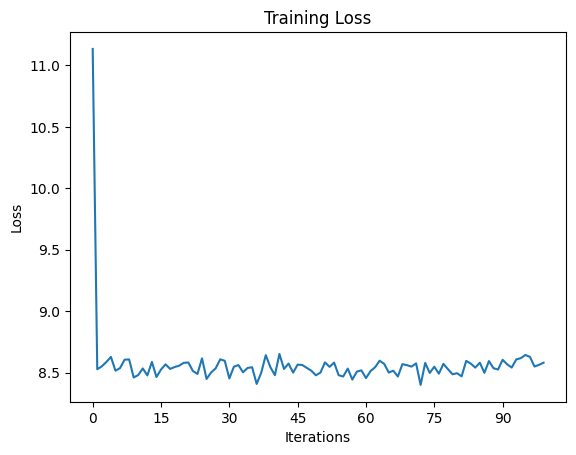

In [28]:
# plot the training loss
ax = plt.figure().gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
ax.plot(train_losses_adam)

In [29]:
# Save the model with timestamp and dimension
tmstmp = time.strftime("%Y%m%d-%H%M%S")
torch.save(model_inception.state_dict(), "Models-pt/{}face_recognition_inception_better_pairing{}.pt".format(DIM, tmstmp))

# clean cuda memory
torch.cuda.empty_cache()

### Evaluarea modelului
Am evaluat modelul vizual prin afișarea distanțelor dintre imagini, deocamdată nu am găsit o metodă de evaluare bazată pe procente

In [30]:
def evaluate3(model, generator, device, batches):
    model.eval()
    tabel_data = "| Anchor - Positive | Anchor - Negative |\n" +\
                 "|" + 19*"-" + "+" + 19*"-" + "|"
        
    with torch.no_grad():
        for i, data in zip(tnrange(batches, desc="Batches", leave=False), generator):
            anchors, positives, negatives = data
            anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32)

            anchors = torch.transpose(anchors, 1, 3)
            positives = torch.transpose(positives, 1, 3)
            negatives = torch.transpose(negatives, 1, 3)
            # print(anchors.shape, positives.shape, negatives.shape)

            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            distance_positive = F.pairwise_distance(anchor_embeddings, positive_embeddings)
            distance_negative = F.pairwise_distance(anchor_embeddings, negative_embeddings)

            # print the distances in a table
            if i == 0:
                print(tabel_data)
            for j in range(len(anchors)):
                tabel_data = f"| {distance_positive[j]:.15f} | {distance_negative[j]:.15f} |"
                print(tabel_data)

In [31]:
def evaluate(model, generator, device, batches):
    model.eval()
    tabel_data = "| AnchorP - Positive | AnchorN - Negative |\n" +\
                 "|" + 20*"-" + "+" + 20*"-" + "|"
        
    with torch.no_grad():
        for i, data in zip(tqdm(range(batches), desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            similarity_positive = F.cosine_similarity(anchor_positive_embeddings, positive_embeddings)
            similarity_negative = F.cosine_similarity(anchor_negative_embeddings, negative_embeddings)

            # print the distances in a table
            if i == 0:
                print(tabel_data)
            for j in range(len(anchors_positives)):
                tabel_data = f"| {similarity_positive[j]:.15f} | {similarity_negative[j]:.15f} |"
                print(tabel_data)
            



In [32]:
generator = batch_generator(full_dataset, pairs, 256)
model_inception = FaceRecInception().to(device)
# tmstmp="20250128-025927"
state_dict = torch.load("Models-pt/{}face_recognition_inception_better_pairing{}.pt".format(DIM, tmstmp), weights_only=True)
# Remove 'module.' prefix from keys if present
state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model_inception.load_state_dict(state_dict=state_dict)
evaluate(model_inception, generator, device, batches=2)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

| AnchorP - Positive | AnchorN - Negative |
|--------------------+--------------------|


| 0.851676106452942 | -0.121644556522369 |
| 0.091101728379726 | 0.869900941848755 |
| 0.648022890090942 | 0.535534143447876 |
| 0.486871391534805 | 0.061206199228764 |
| 0.020293090492487 | 0.993348062038422 |
| 0.873830080032349 | 0.943240523338318 |
| 0.716223239898682 | 0.858976840972900 |
| -0.151483744382858 | 0.623769521713257 |
| -0.060933928936720 | 0.419009506702423 |
| 0.363844454288483 | 0.774471163749695 |
| 0.293806135654449 | -0.110457018017769 |
| -0.472603589296341 | 0.633187353610992 |
| 0.959153890609741 | -0.064252115786076 |
| 0.157684206962585 | -0.370661020278931 |
| 0.962980270385742 | 0.150226205587387 |
| 0.965854823589325 | 0.241359815001488 |
| 0.090399399399757 | 0.134654894471169 |
| 0.664652168750763 | 0.987201690673828 |
| -0.137493550777435 | -0.087263569235802 |
| 0.248296618461609 | -0.185633584856987 |
| 0.969960927963257 | 0.251756131649017 |
| -0.044612314552069 | 0.001231586560607 |
| 0.655799150466919 | 0.657039403915405 |
| 0.807146668434143 | -

| 0.009330403059721 | 0.912887811660767 |
| 0.031636081635952 | 0.084251783788204 |
| 0.998140156269073 | -0.263165414333344 |
| 0.897659659385681 | 0.671044170856476 |
| 0.884541630744934 | -0.319592475891113 |
| 0.099094897508621 | 0.221673160791397 |
| 0.792117655277252 | 0.067779049277306 |
| 0.217117518186569 | 0.585838794708252 |
| 0.191314727067947 | 0.248211339116096 |
| 0.658349394798279 | 0.424836874008179 |
| 0.967710733413696 | 0.712065398693085 |
| 0.700740277767181 | 0.696705460548401 |
| 0.401282250881195 | 0.880333542823792 |
| 0.640546023845673 | 0.298472881317139 |
| 0.885251820087433 | 0.500852108001709 |
| 0.978744029998779 | 0.920116961002350 |
| -0.442468643188477 | 0.889543712139130 |
| 0.281334996223450 | 0.974146723747253 |
| 0.969560623168945 | 0.150007933378220 |
| 0.379931718111038 | 0.507947444915771 |
| 0.989626348018646 | 0.985071778297424 |
| 0.925206840038300 | 0.033206932246685 |
| 0.521451890468597 | 0.915806114673615 |
| 0.821920573711395 | -0.324391

##### Evaluare intuitivă a unui sample de 4 imagini. 2 matched, 2 mismatched

AnchorP - Positive Distance: 0.8711796998977661
 AnchorP - Negative Distance: 0.0722050815820694
  AnchorP - AnchorN Distance: 0.8972203731536865 
   AnchorN - Negative Distance: 0.19483622908592224


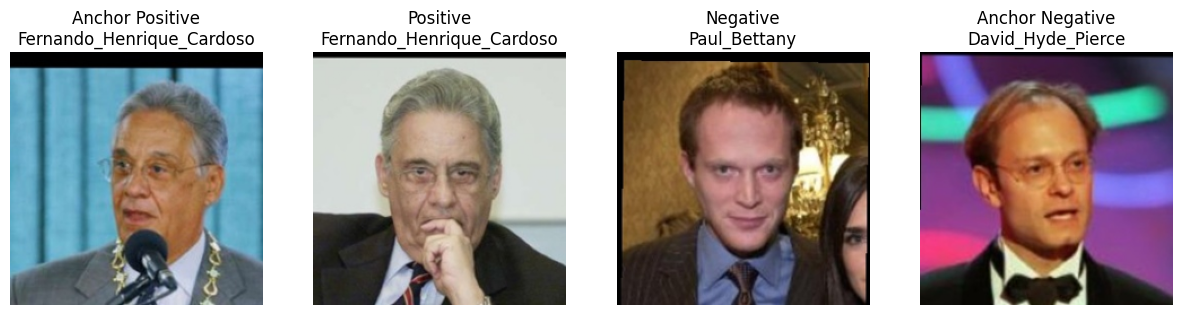

In [33]:
image_generator = batch_generator(full_dataset, pairs, 1)
an_data, pos_data, an_neg_data, neg_data = next(image_generator)
an = torch.tensor(an_data[0], device=device, dtype=torch.float32)
pos = torch.tensor(pos_data[0], device=device, dtype=torch.float32)
neg = torch.tensor(neg_data[0], device=device, dtype=torch.float32)
an_neg = torch.tensor(an_neg_data[0], device=device, dtype=torch.float32)
an_t = torch.transpose(an, 1, 3)
pos_t = torch.transpose(pos, 1, 3)
neg_t = torch.transpose(neg, 1, 3)
an_neg_t = torch.transpose(an_neg, 1, 3)
an_emb = model_inception(an_t)
pos_emb = model_inception(pos_t)
neg_emb = model_inception(neg_t)
an_neg_emb = model_inception(an_neg_t)
distance_positive = F.cosine_similarity(an_emb, pos_emb)
distance_negative = F.cosine_similarity(an_emb, neg_emb)
distance_an_neg = F.cosine_similarity(an_emb, an_neg_emb)
distance_an_neg_negatives = F.cosine_similarity(an_neg_emb, neg_emb)
print(f"AnchorP - Positive Distance: {distance_positive.item()}\n AnchorP - Negative Distance: {distance_negative.item()}\n",
      f" AnchorP - AnchorN Distance: {distance_an_neg.item()} \n   AnchorN - Negative Distance: {distance_an_neg_negatives.item()}")
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 4, 1)
ax.imshow(an[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Anchor Positive\n{an_data[1][0]}")
ax = plt.subplot(1, 4, 2)
ax.imshow(pos[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Positive\n{pos_data[1][0]}")
ax = plt.subplot(1, 4, 3)
ax.imshow(neg[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Negative\n{neg_data[1][0]}")
ax = plt.subplot(1, 4, 4)
ax.imshow(an_neg[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Anchor Negative\n{an_neg_data[1][0]}")
plt.show()


**M-am asigurat că nu am probleme cu ponderile, crezând că ar fi 0**

In [34]:
# Check if weights are zero
for name, param in model_inception.named_parameters():
    print(f"{name} - mean: {param.mean().item()}, std: {param.std().item()}")

# Check if gradients are zero
for name, param in model_inception.named_parameters():
    if param.grad is not None:
        print(f"{name} grad - mean: {param.grad.mean().item()}, std: {param.grad.std().item()}")

conv1.weight - mean: -0.03106689453125, std: 0.07428385317325592
conv1.bias - mean: -0.07371372729539871, std: 0.13540546596050262
inception1.0.weight - mean: -0.024125846102833748, std: 0.09044969826936722
inception1.0.bias - mean: -0.10267894715070724, std: 0.07183025777339935
inception1.2.weight - mean: -0.010016768239438534, std: 0.05284648761153221
inception1.2.bias - mean: -0.07825428247451782, std: 0.05852780491113663
inception3a1x1.0.weight - mean: 0.00013916326861362904, std: 0.06576090306043625
inception3a1x1.0.bias - mean: -0.07221642136573792, std: 0.06427723914384842
inception3a3x3.0.weight - mean: -0.0032883251551538706, std: 0.06454472243785858
inception3a3x3.0.bias - mean: -0.06828932464122772, std: 0.05515606328845024
inception3a3x3.2.weight - mean: -0.0015437559923157096, std: 0.058131661266088486
inception3a3x3.2.bias - mean: -0.08699920773506165, std: 0.07427460700273514
inception3a5x5.0.weight - mean: -0.005319954827427864, std: 0.059053685516119
inception3a5x5.0.b

inception5a3x3.2.weight - mean: -0.012321047484874725, std: 0.0475747212767601
inception5a3x3.2.bias - mean: -0.007479603867977858, std: 0.04530169069766998
inception5a5x5.0.weight - mean: 0.008938036859035492, std: 0.059432145208120346
inception5a5x5.0.bias - mean: -0.008235759101808071, std: 0.04555949196219444
inception5a5x5.2.weight - mean: -0.017634399235248566, std: 0.05409643426537514
inception5a5x5.2.bias - mean: -0.0027729752473533154, std: 0.051778241991996765
inception5apool.1.weight - mean: -0.013391020707786083, std: 0.04557286575436592
inception5apool.1.bias - mean: -0.0018295609625056386, std: 0.046930767595767975
inception5b1x1.0.weight - mean: -0.005584967788308859, std: 0.05253835394978523
inception5b1x1.0.bias - mean: -0.019940007477998734, std: 0.025200819596648216
inception5b3x3.0.weight - mean: -0.010787421837449074, std: 0.05083303526043892
inception5b3x3.0.bias - mean: -0.01905621588230133, std: 0.032923366874456406
inception5b3x3.2.weight - mean: -0.00917143002

In [35]:
# Verify loss function
generator = batch_generator(full_dataset, pairs, 1)

# Ensure optimizer is updating parameters
for epoch in range(10):
    optimizer.zero_grad()
    anchors, positives, anchors_negatives, negatives = next(generator)
    anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32).transpose(1, 3)
    positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
    negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
    anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

    
    anchor_embeddings = model_inception(anchors)
    positive_embeddings = model_inception(positives)
    negative_embeddings = model_inception(negatives)
    anchor_negative_embeddings = model_inception(anchors_negatives)
    
    loss_fn = AMSoftmaxLoss()
    loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings, anchor_negative_embeddings)
    loss.backward()
    optimizer.step()
    
    print(f"Loss: {loss.item()}")
    for name, param in model_inception.named_parameters():
        if param.grad is not None:
            print(f"{name} grad - mean: {param.grad.mean().item()}, std: {param.grad.std().item()}")

Loss: 6.598527431488037
conv1.weight grad - mean: 0.006729023531079292, std: 0.054777950048446655
conv1.bias grad - mean: 0.0667787417769432, std: 0.3270615041255951
inception1.0.weight grad - mean: 0.01743892952799797, std: 0.30946195125579834
inception1.0.bias grad - mean: 0.10832279920578003, std: 0.5089626908302307
inception1.2.weight grad - mean: 0.00015720749797765166, std: 0.007817083038389683
inception1.2.bias grad - mean: 0.023783212527632713, std: 0.07972192764282227
inception3a1x1.0.weight grad - mean: 3.756627847906202e-05, std: 0.0007377721485681832
inception3a1x1.0.bias grad - mean: 0.0015454045496881008, std: 0.006821575574576855
inception3a3x3.0.weight grad - mean: 0.0006196259637363255, std: 0.012020714581012726
inception3a3x3.0.bias grad - mean: 0.03525674343109131, std: 0.13398036360740662
inception3a3x3.2.weight grad - mean: 8.296692976728082e-05, std: 0.004177258349955082
inception3a3x3.2.bias grad - mean: 0.004397522658109665, std: 0.007552062626928091
inception3a

Loss: 12.084864616394043
conv1.weight grad - mean: 0.022564126178622246, std: 0.13483119010925293
conv1.bias grad - mean: 0.12486585974693298, std: 0.6130498647689819
inception1.0.weight grad - mean: 0.05478108674287796, std: 0.7696200609207153
inception1.0.bias grad - mean: 0.20948734879493713, std: 0.9308303594589233
inception1.2.weight grad - mean: 0.00036497076507657766, std: 0.014295857399702072
inception1.2.bias grad - mean: 0.04223662242293358, std: 0.1500522792339325
inception3a1x1.0.weight grad - mean: -2.437790271869744e-06, std: 0.0013386051869019866
inception3a1x1.0.bias grad - mean: 0.0018732160096988082, std: 0.009412677027285099
inception3a3x3.0.weight grad - mean: 0.00116134958807379, std: 0.022303206846117973
inception3a3x3.0.bias grad - mean: 0.06724141538143158, std: 0.2556264400482178
inception3a3x3.2.weight grad - mean: 0.00015518537838943303, std: 0.006473703775554895
inception3a3x3.2.bias grad - mean: 0.008291982114315033, std: 0.014433096162974834
inception3a5x5

inception3a1x1.0.bias grad - mean: 0.0013904444640502334, std: 0.006989889778196812
inception3a3x3.0.weight grad - mean: 0.0008809480932541192, std: 0.018182039260864258
inception3a3x3.0.bias grad - mean: 0.05103158950805664, std: 0.19212539494037628
inception3a3x3.2.weight grad - mean: 0.00011834994074888527, std: 0.007888900116086006
inception3a3x3.2.bias grad - mean: 0.006378409452736378, std: 0.0110648637637496
inception3a5x5.0.weight grad - mean: -0.00040438614087179303, std: 0.005410521291196346
inception3a5x5.0.bias grad - mean: 0.004281666595488787, std: 0.011009124107658863
inception3a5x5.2.weight grad - mean: -8.836359484121203e-05, std: 0.002403148915618658
inception3a5x5.2.bias grad - mean: 0.0004591727047227323, std: 0.012457063421607018
inception3apool.1.weight grad - mean: -0.0006130255060270429, std: 0.006276707164943218
inception3apool.1.bias grad - mean: -0.003307480365037918, std: 0.00915540475398302
inception3b1x1.0.weight grad - mean: -3.347400343045592e-05, std: 0

inception4a3x3.2.bias grad - mean: -4.306117418195754e-08, std: 1.9734540046556504e-07
inception4a5x5.0.weight grad - mean: 0.0010027189273387194, std: 0.013097376562654972
inception4a5x5.0.bias grad - mean: -6.056284007627255e-08, std: 3.4529662684690265e-07
inception4a5x5.2.weight grad - mean: 0.0012652961304411292, std: 0.04678665101528168
inception4a5x5.2.bias grad - mean: -4.212011717186215e-08, std: 1.684915105215623e-07
inception4apool.1.weight grad - mean: -2.9989047269779467e-12, std: 7.332487395039777e-11
inception4apool.1.bias grad - mean: -5.216795284602657e-14, std: 5.902618346355359e-13
inception4b1x1.0.weight grad - mean: -0.00012540175521280617, std: 0.0004763773758895695
inception4b1x1.0.bias grad - mean: 1.7911778726897865e-09, std: 2.4304389611984334e-09
inception4b3x3.0.weight grad - mean: -0.0012556283036246896, std: 0.011538940481841564
inception4b3x3.0.bias grad - mean: 2.965793655107518e-08, std: 6.202635205454499e-08
inception4b3x3.2.weight grad - mean: -0.0006

inception4bpool.1.weight grad - mean: -6.444852624554187e-05, std: 0.0006095677963458002
inception4bpool.1.bias grad - mean: -1.4330280885543889e-11, std: 6.797123974777719e-10
inception4c1x1.0.weight grad - mean: -5.48027855984401e-06, std: 0.00017720343021210283
inception4c1x1.0.bias grad - mean: -2.016475961902353e-12, std: 7.48151280510756e-12
inception4c3x3.0.weight grad - mean: -0.0012904556933790445, std: 0.01514276023954153
inception4c3x3.0.bias grad - mean: -1.9464679867908785e-10, std: 4.984387347306551e-10
inception4c3x3.2.weight grad - mean: -0.0002536182291805744, std: 0.00302674132399261
inception4c3x3.2.bias grad - mean: -5.149433830731187e-12, std: 1.2745180778817033e-11
inception4c5x5.0.weight grad - mean: 0.001991026336327195, std: 0.010027906857430935
inception4c5x5.0.bias grad - mean: 2.3681798189123526e-10, std: 4.303068179556391e-10
inception4c5x5.2.weight grad - mean: -0.00047502294182777405, std: 0.011728491634130478
inception4c5x5.2.bias grad - mean: -2.1117255

inception4e5x5.0.weight grad - mean: 9.9533936008811e-05, std: 0.007748166099190712
inception4e5x5.0.bias grad - mean: -1.0863433023695739e-14, std: 6.659575641594292e-14
inception4e5x5.2.weight grad - mean: -0.00012886746844742447, std: 0.0049803601577878
inception4e5x5.2.bias grad - mean: -1.3056749242920207e-15, std: 7.419542749826681e-15
inception5a1x1.0.weight grad - mean: -1.706701732473448e-05, std: 0.0022033851128071547
inception5a1x1.0.bias grad - mean: -2.427149352253352e-16, std: 9.706415240383045e-16
inception5a3x3.0.weight grad - mean: 0.0006370428018271923, std: 0.026543179526925087
inception5a3x3.0.bias grad - mean: -1.8467513918361708e-16, std: 3.5013764941750755e-15
inception5a3x3.2.weight grad - mean: 0.00039748981362208724, std: 0.04319864884018898
inception5a3x3.2.bias grad - mean: -1.3127771565884051e-17, std: 2.0634686095092258e-15
inception5a5x5.0.weight grad - mean: -0.0025732871145009995, std: 0.06726114451885223
inception5a5x5.0.bias grad - mean: -2.6667703672

inception5a5x5.0.weight grad - mean: -0.00273541989736259, std: 0.07456226646900177
inception5a5x5.0.bias grad - mean: -4.404586572315412e-15, std: 1.3005061810171092e-14
inception5a5x5.2.weight grad - mean: 0.005938754417002201, std: 0.17917077243328094
inception5a5x5.2.bias grad - mean: 5.764191554963522e-16, std: 3.180157460137248e-15
inception5apool.1.weight grad - mean: 0.00018036272376775742, std: 0.004569729790091515
inception5apool.1.bias grad - mean: -1.2267298918909234e-16, std: 6.542463426350903e-16
inception5b1x1.0.weight grad - mean: 0.0002238094893982634, std: 0.0035549167077988386
inception5b1x1.0.bias grad - mean: 4.8882019095958844e-18, std: 3.431159408376495e-17
inception5b3x3.0.weight grad - mean: -0.0032444740645587444, std: 0.10368236154317856
inception5b3x3.0.bias grad - mean: -1.5046473575854697e-16, std: 1.0733272223548249e-15
inception5b3x3.2.weight grad - mean: -0.00020194196258671582, std: 0.010116341523826122
inception5b3x3.2.bias grad - mean: 4.905926735761

### Folosirea librăriei [FiftyOne](https://voxel51.com/)
**Încarc un dataset de testare compus din 100 imagini**

In [36]:
# random_samples = fo.Dataset.from_dir(
#     dataset_dir='/home/ichitu/fiftyone/lfw/lfw_funneled',
#     dataset_type=fo.types.dataset_types.ImageClassificationDirectoryTree,
#     name='lfw_funneled_random',
#     overwrite=True,
#     # max_samples=50
    
# )
random_samples = foz.load_zoo_dataset(
    "lfw",
    split="test",
)
random_dataset = LFWDataset(random_samples)

Split 'test' already downloaded


Loading existing dataset 'lfw-test'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


* Preprocesarea și alcătuirea unei liste cu imaginile mele

In [37]:
def preprocess_image(image):
    image = image.resize((224, 224))
    image = transforms.ToTensor()(image)
    # image = F.normalize(image)
    image = image.unsqueeze(0)
    return image

def get_image(image):
    return Image.fromarray(image)

def get_images(images):
    return [get_image(image) for image in images]

def get_image_from_sample(sample):
    return get_image(np.array(sample[0]))

def get_images_from_samples(samples):
    return [get_image_from_sample(sample) for sample in samples]

print(len(random_dataset))
images = get_images_from_samples(random_dataset)
print(len(images))

3708


3708


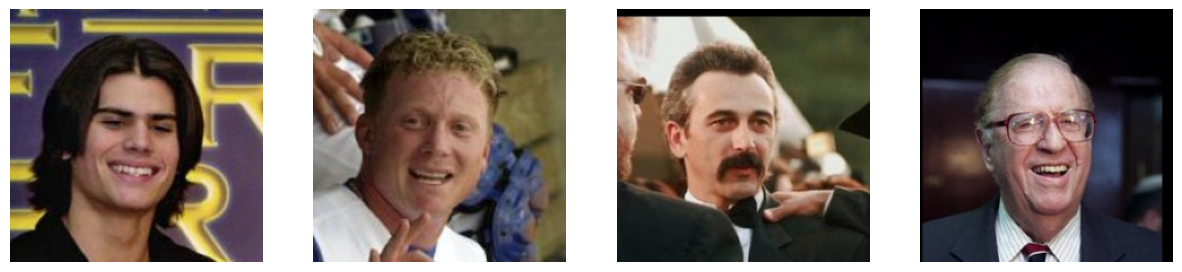

In [38]:
plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.axis("off")

* Creearea unei liste de embeddinguri pentru imagini

In [39]:
def get_embedding(image):
    image = preprocess_image(image)
    # print(image.shape)
    # plt.imshow(image[0])
    # get image on cuda
    image = image.cuda()
    # get embedding
    embedding = model_inception(image)
    return embedding.cpu().detach().numpy()

def get_embeddings(images):
    embeddings = []
    for image in tqdm(images):
       embeddings.append(get_embedding(image))
    return np.array(embeddings)

In [40]:
embeddings = get_embeddings(images)
embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[2])
print(embeddings.shape)

  0%|          | 0/3708 [00:00<?, ?it/s]

(3708, 128)


### Testare acuratețe

In [41]:
from sklearn.metrics import accuracy_score


# print(pairs[0]['matched'])
# print(pairs[0]['mismatched'])

def get_image_from_path(path):
    return Image.open(path)

def get_images_from_pairs(pair, dataset_path='/home/ichitu/fiftyone/lfw/lfw_funneled'):
    matched = pair['matched']
    mismatched = pair['mismatched']
    matched_images = []
    mismatched_images = []
    for match in matched:
        matched_images.append((get_image_from_path(match[0]), get_image_from_path(match[1])))
    for mismatch in mismatched:
        mismatched_images.append((get_image_from_path(mismatch[0]), get_image_from_path(mismatch[1])))
    return matched_images, mismatched_images


def verify(embedding1, embedding2, threshold=0.35):
    embedding1 = torch.tensor(embedding1, device=device, dtype=torch.float32)
    embedding2 = torch.tensor(embedding2, device=device, dtype=torch.float32)
    # print(embedding1.shape, embedding2.shape)
    similarity = F.cosine_similarity(embedding1, embedding2)
    # print(similarity)
    return abs(similarity.item() - 1.0) < threshold
    


predictions = []

# for i in range(0, len(pairs), 2):
#     matched, mismatched = get_images_from_pairs(pairs[i])
#     matched_embeddings1, matched_embeddings2 = [], []
#     for match in matched:
#         matched_embeddings1.append(get_embedding(match[0]))
#         matched_embeddings2.append(get_embedding(match[1]))
#     mismatched_embeddings1, mismatched_embeddings2 = [], []
#     for mismatch in mismatched:
#         mismatched_embeddings1.append(get_embedding(mismatch[0]))
#         mismatched_embeddings2.append(get_embedding(mismatch[1]))
#     for i in range(len(matched_embeddings1)):
#         predictions.append(verify(matched_embeddings1[i], matched_embeddings2[i]))
#     for i in range(len(mismatched_embeddings1)):
#         predictions.append(verify(mismatched_embeddings1[i], mismatched_embeddings2[i]))

for i in tnrange(0, len(pairs)):
    matched, mismatched = get_images_from_pairs(pairs[i])
    matched_embeddings1, matched_embeddings2 = [], []
    for j, match in zip(tnrange(len(matched), desc="Matched", leave=False), matched):
        matched_embeddings1.append(get_embedding(match[0]))
        matched_embeddings2.append(get_embedding(match[1]))
        predictions.append(verify(matched_embeddings1[j], matched_embeddings2[j]))
    mismatched_embeddings1, mismatched_embeddings2 = [], []
    for j, mismatch in zip(tnrange(len(mismatched), desc="Mismatched", leave=False), mismatched):
        mismatched_embeddings1.append(get_embedding(mismatch[0]))
        mismatched_embeddings2.append(get_embedding(mismatch[1]))
        predictions.append(verify(mismatched_embeddings1[j], mismatched_embeddings2[j]))
    for j in tnrange(len(matched), desc="Matched verify", leave=False):
        predictions.append(verify(matched_embeddings1[j], matched_embeddings2[j]))
    for j in tnrange(len(mismatched), desc="Mismatched verify", leave=False):
        predictions.append(verify(mismatched_embeddings1[j], mismatched_embeddings2[j]) == 0)


  0%|          | 0/10 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

In [42]:
real = []
for i in range(0, len(pairs)):
    real.extend([True]*2*len(pairs[i]['matched']))
    real.extend([False]*2*len(pairs[i]['mismatched']))

print(len(real))
for i in range(0, len(real)):
    print(real[i], end=" ")
    if (i+1) % 600 == 0:
        print(f"\n{predictions[i-599:i+1]}")
        print("\n300", end="\n")

12000
True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True

In [43]:
score = accuracy_score(predictions, real)
print(f"Accuracy: {score*100}% for {len(predictions)} samples")

Accuracy: 46.916666666666664% for 12000 samples


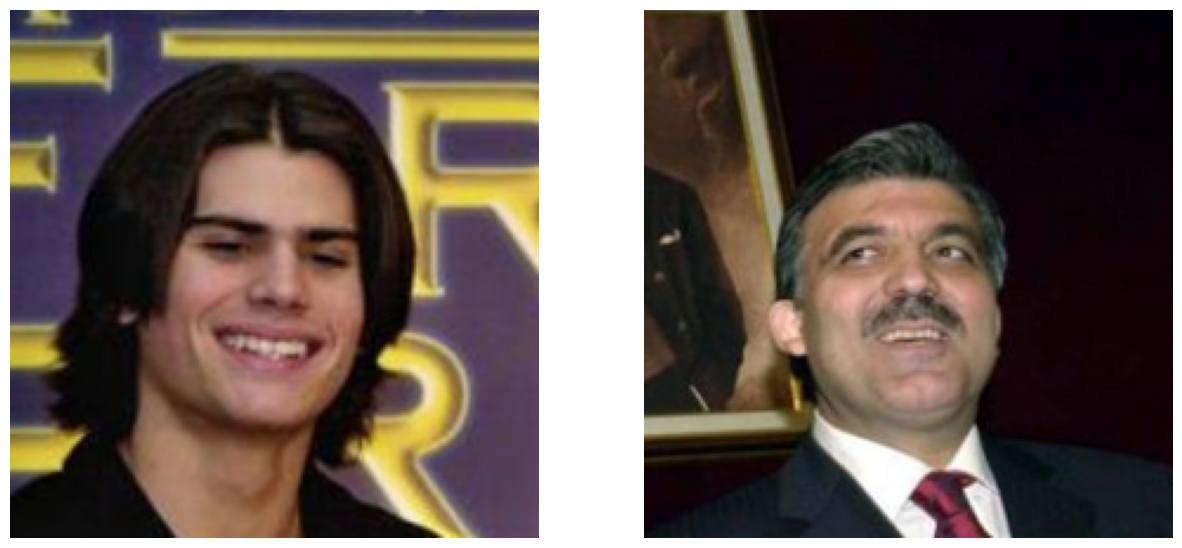

(1, 128) (1, 128)


tensor([[-0.0275, -0.1322,  0.0427,  0.1411,  0.1356, -0.0328,  0.0817,  0.0063,
         -0.0113,  0.1328, -0.0289,  0.0328,  0.0149,  0.0514,  0.1444,  0.1425,
          0.0179,  0.0488, -0.0133, -0.0391, -0.0078,  0.0620,  0.0128, -0.0808,
         -0.0836,  0.0797,  0.0633,  0.0841, -0.0640, -0.1442,  0.0400, -0.0627,
          0.0563, -0.0710, -0.0692, -0.1477,  0.0869, -0.0452, -0.1750,  0.1269,
         -0.0163, -0.1672,  0.0819, -0.0548,  0.0906, -0.0613,  0.0085, -0.0698,
          0.0504,  0.0084,  0.0597,  0.1357, -0.0479, -0.0404,  0.1358,  0.1411,
         -0.0410, -0.1161, -0.0574, -0.0483,  0.0832, -0.0415, -0.0990, -0.0958,
          0.1323,  0.1084,  0.0784, -0.1265, -0.0163, -0.1074, -0.0437, -0.0512,
          0.0346,  0.0994, -0.0176,  0.1352,  0.1057,  0.0423, -0.0700, -0.1392,
         -0.1590, -0.0905,  0.0238,  0.1107,  0.0679, -0.0289,  0.1635, -0.0412,
          0.0179, -0.1407, -0.0650, -0.0766, -0.0837, -0.1377,  0.0770,  0.0858,
         -0.0521, -0.0168,  

In [44]:
# try to get embeddings for two images, i give the path to the images
def get_embeddings(image1, image2):
    # plot the images
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.axis("off")
    plt.show()
    embedding1 = get_embedding(image1)
    embedding2 = get_embedding(image2)
    return embedding1, embedding2

# get the embeddings for two images
embedding1, embedding2 = get_embeddings(images[0], images[7])
print(embedding1.shape, embedding2.shape)

def verify(embedding1, embedding2, threshold=0.1):
    embedding1 = torch.tensor(embedding1, device=device, dtype=torch.float32)
    embedding2 = torch.tensor(embedding2, device=device, dtype=torch.float32)
    print(embedding1)
    print(embedding2)
    similarity = F.cosine_similarity(embedding1, embedding2)
    print(similarity)
    return abs(similarity.item() - 1.0) < threshold

# see if the embeddings are similar
print("Similar" if verify(embedding1, embedding2) else "Not Similar")

* Folosirea [FiftyOne Brain](https://docs.voxel51.com/brain.html) pentru a avea o reprezentare în spațiu 2D a embeddingurilor

In [45]:
results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_tsne",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "tsne",
    
)

results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_pca",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "pca",
    
)

results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_umap",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "umap",
    
)

Generating visualization...


/home/ichitu/machine-learning/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3708 samples in 0.000s...
[t-SNE] Computed neighbors for 3708 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3708
[t-SNE] Computed conditional probabilities for sample 2000 / 3708
[t-SNE] Computed conditional probabilities for sample 3000 / 3708
[t-SNE] Computed conditional probabilities for sample 3708 / 3708
[t-SNE] Mean sigma: 0.033609
[t-SNE] Computed conditional probabilities in 0.053s


[t-SNE] Iteration 50: error = 68.9122162, gradient norm = 0.0257461 (50 iterations in 0.177s)
[t-SNE] Iteration 100: error = 63.4032135, gradient norm = 0.0085576 (50 iterations in 0.150s)


[t-SNE] Iteration 150: error = 61.7563667, gradient norm = 0.0044639 (50 iterations in 0.150s)
[t-SNE] Iteration 200: error = 61.0486298, gradient norm = 0.0034111 (50 iterations in 0.152s)


[t-SNE] Iteration 250: error = 60.6930275, gradient norm = 0.0013629 (50 iterations in 0.158s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.693027
[t-SNE] Iteration 300: error = 1.2251921, gradient norm = 0.0115334 (50 iterations in 0.145s)


[t-SNE] Iteration 350: error = 0.8558765, gradient norm = 0.0087027 (50 iterations in 0.143s)
[t-SNE] Iteration 400: error = 0.7267515, gradient norm = 0.0070879 (50 iterations in 0.147s)


[t-SNE] Iteration 450: error = 0.6640750, gradient norm = 0.0058590 (50 iterations in 0.144s)
[t-SNE] Iteration 500: error = 0.6304795, gradient norm = 0.0048629 (50 iterations in 0.144s)


[t-SNE] Iteration 550: error = 0.6111576, gradient norm = 0.0036590 (50 iterations in 0.144s)
[t-SNE] Iteration 600: error = 0.6001905, gradient norm = 0.0027191 (50 iterations in 0.143s)


[t-SNE] Iteration 650: error = 0.5930045, gradient norm = 0.0018942 (50 iterations in 0.145s)
[t-SNE] Iteration 700: error = 0.5879881, gradient norm = 0.0017012 (50 iterations in 0.143s)


[t-SNE] Iteration 750: error = 0.5836889, gradient norm = 0.0016295 (50 iterations in 0.143s)
[t-SNE] Iteration 800: error = 0.5802478, gradient norm = 0.0013997 (50 iterations in 0.143s)


[t-SNE] Iteration 850: error = 0.5774370, gradient norm = 0.0011792 (50 iterations in 0.144s)
[t-SNE] Iteration 900: error = 0.5752989, gradient norm = 0.0010871 (50 iterations in 0.146s)


[t-SNE] Iteration 950: error = 0.5734600, gradient norm = 0.0009140 (50 iterations in 0.152s)
[t-SNE] Iteration 1000: error = 0.5719087, gradient norm = 0.0008081 (50 iterations in 0.144s)
[t-SNE] KL divergence after 1000 iterations: 0.571909


Generating visualization...


Generating visualization...


/home/ichitu/machine-learning/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP( verbose=True)
Tue Jan 28 19:59:08 2025 Construct fuzzy simplicial set


Tue Jan 28 19:59:13 2025 Finding Nearest Neighbors


Tue Jan 28 19:59:17 2025 Finished Nearest Neighbor Search


Tue Jan 28 19:59:18 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Tue Jan 28 19:59:20 2025 Finished embedding


**Metode de calculare**
* TSNE
* PCA
* UMAP

Din ce am observat, PCA pare o reprezentare mai potrivită

In [46]:

sess = fo.launch_app(dataset=random_samples, port=10100)
sess.open_tab()

<IPython.core.display.Javascript object>